In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00


In [2]:

#create samples :
import os
import torch
import pickle
import pandas as pd

def load_graph(path, is_pickle=True):
    """
    Load a molecule graph (.pkl) or a protein graph (.pt).
    If is_pickle is True, use pickle to load the file; otherwise, use torch.load.
    """
    if is_pickle:
        with open(path, 'rb') as f:
            return pickle.load(f)
    else:
        return torch.load(path)

def prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir):
    """
    Incrementally prepares the dataset and saves each (molecule, protein, target) tuple as a separate .pt file.

    Args:
    - filtered_dataset: The filtered KIBA dataset (DataFrame).
    - molecule_graph_dir: Directory where molecule graphs are stored.
    - protein_graph_dir: Directory where protein graphs are stored.
    - output_dir: Directory to save the prepared dataset incrementally.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in filtered_dataset.iterrows():
        protein_id = row['Target_ID']
        chembl_id = row['Drug_ID']

        # Load the protein graph (.pt)
        pro_graph_path = os.path.join(protein_graph_dir, f"{protein_id}_graph.pt")
        if not os.path.exists(pro_graph_path):
            print(f"Protein graph not found: {protein_id}")
            continue
        pro_graph = load_graph(pro_graph_path, is_pickle=False)

        # Load the molecule graph (.pkl)
        mol_graph_path = os.path.join(molecule_graph_dir, f"{chembl_id}_graph.pkl")
        if not os.path.exists(mol_graph_path):
            print(f"Molecule graph not found: {chembl_id}")
            continue
        mol_graph = load_graph(mol_graph_path)

        # Load target (affinity value)
        target = torch.tensor([row['Y']], dtype=torch.float)

        # Create the sample as a tuple (molecule graph, protein graph, target)
        sample = (mol_graph, pro_graph, target)

        # Save the sample as a .pt file
        sample_path = os.path.join(output_dir, f"sample_{index}.pt")
        torch.save(sample, sample_path)

        if(index%10000 == 0 ):
            print(f"Saved sample {index} as {sample_path}")




# Example usage for individual saving
molecule_graph_dir = '/kaggle/input/graphs/molecule_graphs'  # Directory where molecule graphs are stored
protein_graph_dir = '/kaggle/input/graphs/ProteinGraphs'  # Directory where protein graphs are stored
filtered_dataset_path = '/kaggle/input/graphs/filtered_DavisDataSet.csv'  # Path to the filtered dataset CSV
output_dir = 'prepared_samples/'  # Directory to save individual samples

# Load filtered dataset CSV
filtered_dataset = pd.read_csv(filtered_dataset_path)

# Prepare the dataset incrementally, saving each sample as a .pt file
prepare_dataset_individual_save_as_pt(filtered_dataset, molecule_graph_dir, protein_graph_dir, output_dir)

print("Dataset preparation completed.")



<ipython-input-2-b6d33a83e452>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 0 as prepared_samples/sample_0.pt


<ipython-input-2-b6d33a83e452>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


Saved sample 10000 as prepared_samples/sample_10000.pt


Dataset preparation completed.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class NonLocalBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=None, chunk_size=2048):
        super().__init__()
        self.output_dim = output_dim or input_dim

        # GCN-based projections (Φ, Θ, Γ)
        # Φ: H = σ(Â H W_φ + b_φ), where Â = D^{-1/2} (A + I) D^{-1/2}
        self.W_phi = GCNConv(input_dim, hidden_dim)
        self.W_theta = GCNConv(input_dim, hidden_dim)
        self.W_gamma = GCNConv(input_dim, hidden_dim)

        # Output projection: O = O_{agg} W_{out} + b_{out}
        self.W_out = nn.Linear(hidden_dim, self.output_dim)

        # Residual connection: V_n = O + V_m (if dimensions match)
        self.res_proj = nn.Linear(input_dim, self.output_dim) if input_dim != self.output_dim else nn.Identity()

        self.chunk_size = chunk_size

    def forward(self, V_m, edge_index):
        # Step 1: Compute Φ, Θ, Γ using GCNConv
        # Φ = GCN(V_m, edge_index), Θ = GCN(V_m, edge_index), Γ = GCN(V_m, edge_index)
        phi = self.W_phi(V_m, edge_index)  # Φ ∈ ℝ^{N×h}
        theta = self.W_theta(V_m, edge_index)  # Θ ∈ ℝ^{N×h}
        gamma = self.W_gamma(V_m, edge_index)  # Γ ∈ ℝ^{N×h}

        N = phi.size(0)
        O = torch.zeros_like(gamma)

        # Step 2: Chunked attention computation
        for i in range(0, N, self.chunk_size):
            # For chunk i: Φ_chunk = Φ[i:i+chunk_size]
            phi_chunk = phi[i:i + self.chunk_size]  # Φ_chunk ∈ ℝ^{C×h}

            # Compute similarity scores: S = (Θ Φ_chunk^T) / √h
            sim_chunk = torch.einsum('nh,ch->cn', theta, phi_chunk)  # S ∈ ℝ^{C×N}
            sim_chunk = sim_chunk / (phi.size(1) ** 0.5)  # Scaling by √h

            # Softmax normalization: α = softmax(S, dim=1)
            attn_chunk = F.softmax(sim_chunk, dim=1)  # α ∈ ℝ^{C×N}

            # Aggregate values: O_chunk = α Γ
            O_chunk = torch.einsum('cn,nh->ch', attn_chunk, gamma)  # O_chunk ∈ ℝ^{C×h}
            O[i:i + self.chunk_size] = O_chunk

            del phi_chunk, sim_chunk, attn_chunk, O_chunk
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Step 3: Projection and residual connection
        O_projected = self.W_out(O)  # O_projected ∈ ℝ^{N×d_out}
        V_n = O_projected + self.res_proj(V_m)  # V_n = O_projected + V_m (with dim alignment)
        return V_n

In [4]:
# !rm -rf "TrainingModelNLB"

In [5]:
import os
training_model_dir = os.path.join(os.getcwd(), 'TrainingModelNLB')
os.makedirs(training_model_dir, exist_ok=True)

In [6]:
!cp '/kaggle/input/nbl-ep210/pytorch/default/1/model_epoch210.pt'  'TrainingModelNLB/model_epoch210.pt'
!cp '/kaggle/input/nbl-ep210/pytorch/default/1/training_metrics.pt'  'TrainingModelNLB/training_metrics.pt'

In [7]:
#model one
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import GCNConv, global_mean_pool as gep
from torch_geometric.data import Data, Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# Optional, for plotting:
import matplotlib.pyplot as plt

##############################################################################
#                               1. METRICS
##############################################################################

@torch.no_grad()
def ci_vectorized(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Naive O(N^2) Concordance Index using vectorized GPU operations.
    preds, targets: (N,) on the same device (e.g. cuda).
    """
    # (N, N) differences
    p_diff = preds.unsqueeze(1) - preds.unsqueeze(0)
    t_diff = targets.unsqueeze(1) - targets.unsqueeze(0)
    # mask out pairs where targets are identical
    mask = (t_diff != 0)
    # sign of product => +1 (concordant), 0 (tie), -1 (discordant)
    sign_mat = torch.sign(p_diff * t_diff)
    # step function h(x): 1 if x>0, 0.5 if x=0, 0 if x<0
    h = (sign_mat == 1).float() + 0.5 * (sign_mat == 0).float()
    # apply mask
    h_masked = h * mask.float()
    c = h_masked.sum()
    s = mask.sum().float()
    return (c / s).item() if s > 0 else 0.0

@torch.no_grad()
def mse_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    GPU-friendly MSE using torch's built-in mean squared error.
    """
    return F.mse_loss(preds, targets, reduction='mean').item()

@torch.no_grad()
def pearson_torch(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Pearson correlation coefficient in PyTorch (GPU-friendly).
    preds, targets: (N,) on the same device
    """
    p_centered = preds - preds.mean()
    t_centered = targets - targets.mean()
    cov = (p_centered * t_centered).sum()
    denom = torch.sqrt((p_centered**2).sum()) * torch.sqrt((t_centered**2).sum())
    eps = 1e-8
    return (cov / (denom + eps)).item()

##############################################################################
#                       2. GNN MODEL DEFINITION
##############################################################################

class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, hidden_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output
        self.hidden_dim = hidden_dim

        # Molecular graph pipeline
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_nonlocal = NonLocalBlock(num_features_mol, hidden_dim, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)

        # Protein graph pipeline
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_nonlocal = NonLocalBlock(num_features_pro, hidden_dim, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)

        # Combined layers
        self.fc1 = torch.nn.Linear(2 * output_dim, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.out = torch.nn.Linear(512, self.n_output)

    def forward(self, data_mol, data_pro):
        # Molecular graph input
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        mol_x = self.mol_conv1(mol_x, mol_edge_index)
        mol_x = self.relu(mol_x)
        mol_x = self.mol_nonlocal(mol_x ,mol_edge_index)  # Non-local block
        mol_x = self.mol_conv3(mol_x, mol_edge_index)
        mol_x = self.relu(mol_x)
        mol_x = gep(mol_x, mol_batch)  # Global pooling
        mol_x = self.relu(self.mol_fc_g1(mol_x))
        mol_x = self.dropout(mol_x)
        mol_x = self.mol_fc_g2(mol_x)
        mol_x = self.dropout(mol_x)

        # Protein graph input
        pro_x, pro_edge_index, pro_batch = data_pro.x, data_pro.edge_index, data_pro.batch
        pro_x = self.pro_conv1(pro_x, pro_edge_index)
        pro_x = self.relu(pro_x)
        pro_x = self.pro_nonlocal(pro_x,pro_edge_index)  # Non-local block
        pro_x = self.pro_conv3(pro_x, pro_edge_index)
        pro_x = self.relu(pro_x)
        pro_x = gep(pro_x, pro_batch)  # Global pooling
        pro_x = self.relu(self.pro_fc_g1(pro_x))
        pro_x = self.dropout(pro_x)
        pro_x = self.pro_fc_g2(pro_x)
        pro_x = self.dropout(pro_x)

        # Concatenate molecular and protein features
        xc = torch.cat((mol_x, pro_x), dim=1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out



##############################################################################
#                   3. DATA LOADING HELPERS
##############################################################################

warnings.filterwarnings('ignore', category=FutureWarning)

def load_sample(path):
    """
    Load a .pt sample, fix up 'x' and 'edge_index', return (mol_data, pro_data, target).
    """
    sample = torch.load(path)
    mol_data, pro_data, target = sample[0], sample[1], sample[2]

    # Convert dict to Data if needed
    if isinstance(mol_data, dict):
        mol_data = Data(**mol_data)
    if isinstance(pro_data, dict):
        pro_data = Data(**pro_data)

    # Fix x
    if not hasattr(mol_data, 'x') or mol_data.x is None:
        if hasattr(mol_data, 'features'):
            mol_data.x = mol_data.features
            del mol_data.features
        else:
            raise ValueError("mol_data missing 'x' or 'features'")
    if not hasattr(pro_data, 'x') or pro_data.x is None:
        if hasattr(pro_data, 'features'):
            pro_data.x = pro_data.features
            del pro_data.features
        else:
            raise ValueError("pro_data missing 'x' or 'features'")

    mol_data.x = torch.as_tensor(mol_data.x, dtype=torch.float32)
    pro_data.x = torch.as_tensor(pro_data.x, dtype=torch.float32)

    # Fix edge_index
    def fix_edge_index(d):
        if not isinstance(d.edge_index, torch.Tensor):
            d.edge_index = torch.tensor(d.edge_index, dtype=torch.long)
        else:
            d.edge_index = d.edge_index.long()
        if d.edge_index.shape[0] != 2:
            d.edge_index = d.edge_index.t()
        d.num_nodes = d.x.size(0)

    fix_edge_index(mol_data)
    fix_edge_index(pro_data)

    return (mol_data, pro_data, target)

def batch_loader(file_list, sample_dir, batch_size):
    """
    Yields batches of (mol_data, pro_data, target) from file_list.
    """
    batch = []
    for file_name in file_list:
        path = os.path.join(sample_dir, file_name)
        sample = load_sample(path)
        batch.append(sample)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

##############################################################################
#              4. TRAINING / EVALUATION WITH METRICS EACH EPOCH
##############################################################################
import os
import torch

def train_and_evaluate(sample_dir, num_epochs=10, test_size=0.2, lr=0.001):
    """
    Trains the GNN model, evaluates on train & test each epoch, saves metrics + checkpoints.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running on {device}.")

    # Gather samples
    sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.pt')]
    assert len(sample_files) > 0, "No .pt files found in sample_dir!"

    # Split
    train_files, test_files = train_test_split(sample_files, test_size=test_size, random_state=42)

    # Make checkpoint dir
    training_model_dir = os.path.join(os.getcwd(), 'TrainingModelNLB')
    os.makedirs(training_model_dir, exist_ok=True)
    print(f"Checkpoints will be saved to: {training_model_dir}")

    metrics_path = os.path.join(training_model_dir, "training_metrics.pt")

    # Load existing metrics if available (Ensures metrics continue from previous runs)
    if os.path.exists(metrics_path):
        saved_metrics = torch.load(metrics_path)
        train_metrics = saved_metrics['train_metrics']
        test_metrics = saved_metrics['test_metrics']
        print("Loaded previous training metrics!")
    else:
        train_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        test_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
        print("Starting fresh metrics tracking.")

    # Infer input dims from one sample
    sample0 = load_sample(os.path.join(sample_dir, train_files[0]))
    mol_data0, pro_data0 = sample0[0], sample0[1]
    num_features_mol = mol_data0.x.size(1)
    num_features_pro = pro_data0.x.size(1)

    # Initialize model
    model = GNNNet(num_features_mol=num_features_mol,
                   num_features_pro=num_features_pro).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    # Possibly resume from checkpoint
    start_epoch = 1
    existing_checkpoints = [
        f for f in os.listdir(training_model_dir)
        if f.endswith('.pt') and f.startswith('model_epoch')
    ]
    last_ckpt_path = None  # Track previous checkpoint for deletion

    if existing_checkpoints:
        latest_ckpt = max(existing_checkpoints, key=lambda x: int(x.split('_epoch')[1].split('.pt')[0]))
        ckpt_path = os.path.join(training_model_dir, latest_ckpt)
        print(f"Loading checkpoint from {ckpt_path}")
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        loaded_epoch = ckpt['epoch']
        start_epoch = loaded_epoch + 1
        last_ckpt_path = ckpt_path  # Store last checkpoint path for deletion
        print(f"Resuming from epoch {start_epoch}")
    else:
        print("No existing checkpoint found; starting fresh.")

    @torch.no_grad()
    def evaluate(files):
        model.eval()
        all_preds = []
        all_targets = []
        batch_eval_size = 200
        for batch_samples in batch_loader(files, sample_dir, batch_eval_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device)

            out = model(mol_batch, pro_batch).view(-1)
            all_preds.append(out)
            all_targets.append(t_tensor)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        mse_val = mse_torch(all_preds, all_targets)
        ci_val = ci_vectorized(all_preds, all_targets)
        pearson_val = pearson_torch(all_preds, all_targets)
        return mse_val, ci_val, pearson_val

    # Training loop
    batch_size = 61
    for epoch in tqdm(range(start_epoch, num_epochs + 1), desc="Training", unit="epoch"):
        model.train()
        running_loss = 0.0

        for batch_samples in batch_loader(train_files, sample_dir, batch_size):
            mol_list, pro_list, tgt_list = [], [], []
            for (md, pd, t) in batch_samples:
                mol_list.append(md)
                pro_list.append(pd)
                tgt_list.append(t)

            mol_batch = Batch.from_data_list(mol_list).to(device)
            pro_batch = Batch.from_data_list(pro_list).to(device)
            t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device).view(-1)

            optimizer.zero_grad()
            out = model(mol_batch, pro_batch).view(-1)
            loss = loss_fn(out, t_tensor)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_samples)

        avg_loss = running_loss / len(train_files)
        tqdm.write(f"[Epoch {epoch}/{num_epochs}] Training Loss: {avg_loss:.4f}")

        # Evaluate on train & test
        train_mse, train_ci, train_pearson = evaluate(train_files)
        test_mse, test_ci, test_pearson = evaluate(test_files)

        train_metrics['epoch'].append(epoch)
        train_metrics['mse'].append(train_mse)
        train_metrics['ci'].append(train_ci)
        train_metrics['pearson'].append(train_pearson)

        test_metrics['epoch'].append(epoch)
        test_metrics['mse'].append(test_mse)
        test_metrics['ci'].append(test_ci)
        test_metrics['pearson'].append(test_pearson)

        tqdm.write(f"  Train => MSE={train_mse:.4f}, CI={train_ci:.4f}, Pearson={train_pearson:.4f}")
        tqdm.write(f"  Test  => MSE={test_mse:.4f}, CI={test_ci:.4f}, Pearson={test_pearson:.4f}")

        # Save new checkpoint
        ckpt_name = f"model_epoch{epoch}.pt"
        ckpt_path = os.path.join(training_model_dir, ckpt_name)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, ckpt_path)
        tqdm.write(f"Checkpoint saved at epoch {epoch}")

        # Delete the previous checkpoint after saving the new one
        if last_ckpt_path and os.path.exists(last_ckpt_path):
            os.remove(last_ckpt_path)
            tqdm.write(f"Deleted previous checkpoint: {last_ckpt_path}")

        # Update last checkpoint path
        last_ckpt_path = ckpt_path

        # Save/Update the metrics after each epoch
        torch.save({
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }, metrics_path)

    # Final evaluations
    final_train_mse, final_train_ci, final_train_pearson = evaluate(train_files)
    final_test_mse, final_test_ci, final_test_pearson = evaluate(test_files)
    print(f"\nFinal Train => MSE={final_train_mse:.4f}, CI={final_train_ci:.4f}, Pearson={final_train_pearson:.4f}")
    print(f"Final Test  => MSE={final_test_mse:.4f}, CI={final_test_ci:.4f}, Pearson={final_test_pearson:.4f}")

    # Save final metrics
    torch.save({
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }, metrics_path)
    print(f"Metrics saved to {metrics_path}")

    return train_metrics, test_metrics


##############################################################################
#               5. OPTIONAL: PLOT THE SAVED METRICS
##############################################################################

def plot_metrics(checkpoint_dir='TrainingModelNLB'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.legend()
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()

##############################################################################
#                                 MAIN
##############################################################################

if __name__ == "__main__":
    # Adjust the paths/parameters as needed
    SAMPLE_DIR = "prepared_samples"   # Directory with your .pt samples
    NUM_EPOCHS = 250
    TEST_SPLIT = 0.2
    LR = 0.001

    # 1) Train and evaluate
    train_metrics, test_metrics = train_and_evaluate(
        sample_dir=SAMPLE_DIR,
        num_epochs=NUM_EPOCHS,
        test_size=TEST_SPLIT,
        lr=LR
    )

    # 2) Plot the metrics
    plot_metrics('TrainingModelNLB')

Running on cuda.
Checkpoints will be saved to: /kaggle/working/TrainingModelNLB
Loaded previous training metrics!
GNNNet Loaded


Loading checkpoint from /kaggle/working/TrainingModelNLB/model_epoch210.pt
Resuming from epoch 211


Training:   0%|          | 0/40 [00:00<?, ?epoch/s]

Training:   0%|          | 0/40 [08:01<?, ?epoch/s]

[Epoch 211/250] Training Loss: 0.2338


Training:   0%|          | 0/40 [23:43<?, ?epoch/s]

Training:   0%|          | 0/40 [23:43<?, ?epoch/s]

Training:   0%|          | 0/40 [23:43<?, ?epoch/s]

Training:   0%|          | 0/40 [23:43<?, ?epoch/s]

Training:   2%|▎         | 1/40 [23:43<15:25:17, 1423.53s/epoch]

  Train => MSE=0.1619, CI=0.9035, Pearson=0.8900
  Test  => MSE=0.1710, CI=0.8962, Pearson=0.8811
Checkpoint saved at epoch 211
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch210.pt


Training:   2%|▎         | 1/40 [31:41<15:25:17, 1423.53s/epoch]

[Epoch 212/250] Training Loss: 0.2256


Training:   2%|▎         | 1/40 [47:21<15:25:17, 1423.53s/epoch]

Training:   2%|▎         | 1/40 [47:21<15:25:17, 1423.53s/epoch]

Training:   2%|▎         | 1/40 [47:21<15:25:17, 1423.53s/epoch]

Training:   2%|▎         | 1/40 [47:21<15:25:17, 1423.53s/epoch]

Training:   5%|▌         | 2/40 [47:21<14:59:30, 1420.28s/epoch]

  Train => MSE=0.1459, CI=0.9069, Pearson=0.8980
  Test  => MSE=0.1635, CI=0.8997, Pearson=0.8835
Checkpoint saved at epoch 212
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch211.pt


Training:   5%|▌         | 2/40 [55:18<14:59:30, 1420.28s/epoch]

[Epoch 213/250] Training Loss: 0.2204


Training:   5%|▌         | 2/40 [1:10:58<14:59:30, 1420.28s/epoch]

Training:   5%|▌         | 2/40 [1:10:58<14:59:30, 1420.28s/epoch]

Training:   5%|▌         | 2/40 [1:10:58<14:59:30, 1420.28s/epoch]

Training:   5%|▌         | 2/40 [1:10:58<14:59:30, 1420.28s/epoch]

Training:   8%|▊         | 3/40 [1:10:58<14:35:00, 1418.93s/epoch]

  Train => MSE=0.1432, CI=0.9085, Pearson=0.9000
  Test  => MSE=0.1684, CI=0.8972, Pearson=0.8801
Checkpoint saved at epoch 213
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch212.pt


Training:   8%|▊         | 3/40 [1:18:55<14:35:00, 1418.93s/epoch]

[Epoch 214/250] Training Loss: 0.2208


Training:   8%|▊         | 3/40 [1:34:37<14:35:00, 1418.93s/epoch]

Training:   8%|▊         | 3/40 [1:34:37<14:35:00, 1418.93s/epoch]

Training:   8%|▊         | 3/40 [1:34:37<14:35:00, 1418.93s/epoch]

Training:   8%|▊         | 3/40 [1:34:37<14:35:00, 1418.93s/epoch]

Training:  10%|█         | 4/40 [1:34:37<14:11:17, 1418.82s/epoch]

  Train => MSE=0.1534, CI=0.9064, Pearson=0.8950
  Test  => MSE=0.1776, CI=0.8948, Pearson=0.8750
Checkpoint saved at epoch 214
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch213.pt


Training:  10%|█         | 4/40 [1:42:33<14:11:17, 1418.82s/epoch]

[Epoch 215/250] Training Loss: 0.2202


Training:  10%|█         | 4/40 [1:58:13<14:11:17, 1418.82s/epoch]

Training:  10%|█         | 4/40 [1:58:13<14:11:17, 1418.82s/epoch]

Training:  10%|█         | 4/40 [1:58:13<14:11:17, 1418.82s/epoch]

Training:  10%|█         | 4/40 [1:58:13<14:11:17, 1418.82s/epoch]

Training:  12%|█▎        | 5/40 [1:58:13<13:47:04, 1417.83s/epoch]

  Train => MSE=0.1462, CI=0.9078, Pearson=0.8984
  Test  => MSE=0.1725, CI=0.8953, Pearson=0.8776
Checkpoint saved at epoch 215
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch214.pt


Training:  12%|█▎        | 5/40 [2:06:10<13:47:04, 1417.83s/epoch]

[Epoch 216/250] Training Loss: 0.2122


Training:  12%|█▎        | 5/40 [2:21:50<13:47:04, 1417.83s/epoch]

Training:  12%|█▎        | 5/40 [2:21:50<13:47:04, 1417.83s/epoch]

Training:  12%|█▎        | 5/40 [2:21:50<13:47:04, 1417.83s/epoch]

Training:  12%|█▎        | 5/40 [2:21:50<13:47:04, 1417.83s/epoch]

Training:  15%|█▌        | 6/40 [2:21:50<13:23:18, 1417.59s/epoch]

  Train => MSE=0.1425, CI=0.9068, Pearson=0.8999
  Test  => MSE=0.1748, CI=0.8943, Pearson=0.8751
Checkpoint saved at epoch 216
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch215.pt


Training:  15%|█▌        | 6/40 [2:29:48<13:23:18, 1417.59s/epoch]

[Epoch 217/250] Training Loss: 0.2179


Training:  15%|█▌        | 6/40 [2:45:28<13:23:18, 1417.59s/epoch]

Training:  15%|█▌        | 6/40 [2:45:28<13:23:18, 1417.59s/epoch]

Training:  15%|█▌        | 6/40 [2:45:28<13:23:18, 1417.59s/epoch]

Training:  15%|█▌        | 6/40 [2:45:28<13:23:18, 1417.59s/epoch]

Training:  18%|█▊        | 7/40 [2:45:28<12:59:39, 1417.56s/epoch]

  Train => MSE=0.1406, CI=0.9111, Pearson=0.9029
  Test  => MSE=0.1764, CI=0.8997, Pearson=0.8753
Checkpoint saved at epoch 217
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch216.pt


Training:  18%|█▊        | 7/40 [2:53:24<12:59:39, 1417.56s/epoch]

[Epoch 218/250] Training Loss: 0.2129


Training:  18%|█▊        | 7/40 [3:09:06<12:59:39, 1417.56s/epoch]

Training:  18%|█▊        | 7/40 [3:09:06<12:59:39, 1417.56s/epoch]

Training:  18%|█▊        | 7/40 [3:09:06<12:59:39, 1417.56s/epoch]

Training:  18%|█▊        | 7/40 [3:09:06<12:59:39, 1417.56s/epoch]

Training:  20%|██        | 8/40 [3:09:06<12:36:05, 1417.68s/epoch]

  Train => MSE=0.1457, CI=0.9136, Pearson=0.9063
  Test  => MSE=0.1763, CI=0.8989, Pearson=0.8807
Checkpoint saved at epoch 218
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch217.pt


Training:  20%|██        | 8/40 [3:17:02<12:36:05, 1417.68s/epoch]

[Epoch 219/250] Training Loss: 0.2037


Training:  20%|██        | 8/40 [3:32:42<12:36:05, 1417.68s/epoch]

Training:  20%|██        | 8/40 [3:32:42<12:36:05, 1417.68s/epoch]

Training:  20%|██        | 8/40 [3:32:42<12:36:05, 1417.68s/epoch]

Training:  20%|██        | 8/40 [3:32:42<12:36:05, 1417.68s/epoch]

Training:  22%|██▎       | 9/40 [3:32:42<12:12:19, 1417.39s/epoch]

  Train => MSE=0.1313, CI=0.9105, Pearson=0.9081
  Test  => MSE=0.1763, CI=0.8919, Pearson=0.8738
Checkpoint saved at epoch 219
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch218.pt


Training:  22%|██▎       | 9/40 [3:40:39<12:12:19, 1417.39s/epoch]

[Epoch 220/250] Training Loss: 0.2109


Training:  22%|██▎       | 9/40 [3:56:20<12:12:19, 1417.39s/epoch]

Training:  22%|██▎       | 9/40 [3:56:20<12:12:19, 1417.39s/epoch]

Training:  22%|██▎       | 9/40 [3:56:20<12:12:19, 1417.39s/epoch]

Training:  22%|██▎       | 9/40 [3:56:20<12:12:19, 1417.39s/epoch]

Training:  25%|██▌       | 10/40 [3:56:20<11:48:42, 1417.43s/epoch]

  Train => MSE=0.1463, CI=0.9027, Pearson=0.9014
  Test  => MSE=0.1894, CI=0.8839, Pearson=0.8676
Checkpoint saved at epoch 220
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch219.pt


Training:  25%|██▌       | 10/40 [4:04:16<11:48:42, 1417.43s/epoch]

[Epoch 221/250] Training Loss: 0.2120


Training:  25%|██▌       | 10/40 [4:19:57<11:48:42, 1417.43s/epoch]

Training:  25%|██▌       | 10/40 [4:19:57<11:48:42, 1417.43s/epoch]

Training:  25%|██▌       | 10/40 [4:19:57<11:48:42, 1417.43s/epoch]

Training:  25%|██▌       | 10/40 [4:19:57<11:48:42, 1417.43s/epoch]

Training:  28%|██▊       | 11/40 [4:19:57<11:25:01, 1417.28s/epoch]

  Train => MSE=0.1350, CI=0.9132, Pearson=0.9059
  Test  => MSE=0.1784, CI=0.8946, Pearson=0.8715
Checkpoint saved at epoch 221
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch220.pt


Training:  28%|██▊       | 11/40 [4:27:54<11:25:01, 1417.28s/epoch]

[Epoch 222/250] Training Loss: 0.2089


Training:  28%|██▊       | 11/40 [4:43:35<11:25:01, 1417.28s/epoch]

Training:  28%|██▊       | 11/40 [4:43:35<11:25:01, 1417.28s/epoch]

Training:  28%|██▊       | 11/40 [4:43:35<11:25:01, 1417.28s/epoch]

Training:  28%|██▊       | 11/40 [4:43:35<11:25:01, 1417.28s/epoch]

Training:  30%|███       | 12/40 [4:43:35<11:01:34, 1417.65s/epoch]

  Train => MSE=0.1320, CI=0.9086, Pearson=0.9081
  Test  => MSE=0.1824, CI=0.8892, Pearson=0.8701
Checkpoint saved at epoch 222
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch221.pt


Training:  30%|███       | 12/40 [4:51:32<11:01:34, 1417.65s/epoch]

[Epoch 223/250] Training Loss: 0.2007


Training:  30%|███       | 12/40 [5:07:13<11:01:34, 1417.65s/epoch]

Training:  30%|███       | 12/40 [5:07:13<11:01:34, 1417.65s/epoch]

Training:  30%|███       | 12/40 [5:07:13<11:01:34, 1417.65s/epoch]

Training:  30%|███       | 12/40 [5:07:13<11:01:34, 1417.65s/epoch]

Training:  32%|███▎      | 13/40 [5:07:13<10:37:59, 1417.75s/epoch]

  Train => MSE=0.1327, CI=0.9108, Pearson=0.9072
  Test  => MSE=0.1853, CI=0.8905, Pearson=0.8662
Checkpoint saved at epoch 223
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch222.pt


Training:  32%|███▎      | 13/40 [5:15:10<10:37:59, 1417.75s/epoch]

[Epoch 224/250] Training Loss: 0.2051


Training:  32%|███▎      | 13/40 [5:30:51<10:37:59, 1417.75s/epoch]

Training:  32%|███▎      | 13/40 [5:30:51<10:37:59, 1417.75s/epoch]

Training:  32%|███▎      | 13/40 [5:30:51<10:37:59, 1417.75s/epoch]

Training:  32%|███▎      | 13/40 [5:30:51<10:37:59, 1417.75s/epoch]

Training:  35%|███▌      | 14/40 [5:30:51<10:14:21, 1417.77s/epoch]

  Train => MSE=0.1328, CI=0.9114, Pearson=0.9075
  Test  => MSE=0.1793, CI=0.8957, Pearson=0.8710
Checkpoint saved at epoch 224
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch223.pt


Training:  35%|███▌      | 14/40 [5:38:48<10:14:21, 1417.77s/epoch]

[Epoch 225/250] Training Loss: 0.2069


Training:  35%|███▌      | 14/40 [5:54:29<10:14:21, 1417.77s/epoch]

Training:  35%|███▌      | 14/40 [5:54:29<10:14:21, 1417.77s/epoch]

Training:  35%|███▌      | 14/40 [5:54:29<10:14:21, 1417.77s/epoch]

Training:  35%|███▌      | 14/40 [5:54:29<10:14:21, 1417.77s/epoch]

Training:  38%|███▊      | 15/40 [5:54:29<9:50:44, 1417.79s/epoch] 

  Train => MSE=0.1308, CI=0.9147, Pearson=0.9098
  Test  => MSE=0.1892, CI=0.8927, Pearson=0.8648
Checkpoint saved at epoch 225
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch224.pt


Training:  38%|███▊      | 15/40 [6:02:27<9:50:44, 1417.79s/epoch]

[Epoch 226/250] Training Loss: 0.2011


Training:  38%|███▊      | 15/40 [6:18:08<9:50:44, 1417.79s/epoch]

Training:  38%|███▊      | 15/40 [6:18:08<9:50:44, 1417.79s/epoch]

Training:  38%|███▊      | 15/40 [6:18:08<9:50:44, 1417.79s/epoch]

Training:  38%|███▊      | 15/40 [6:18:08<9:50:44, 1417.79s/epoch]

Training:  40%|████      | 16/40 [6:18:08<9:27:15, 1418.16s/epoch]

  Train => MSE=0.1251, CI=0.9094, Pearson=0.9127
  Test  => MSE=0.1843, CI=0.8872, Pearson=0.8681
Checkpoint saved at epoch 226
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch225.pt


Training:  40%|████      | 16/40 [6:26:05<9:27:15, 1418.16s/epoch]

[Epoch 227/250] Training Loss: 0.1966


Training:  40%|████      | 16/40 [6:41:46<9:27:15, 1418.16s/epoch]

Training:  40%|████      | 16/40 [6:41:46<9:27:15, 1418.16s/epoch]

Training:  40%|████      | 16/40 [6:41:46<9:27:15, 1418.16s/epoch]

Training:  40%|████      | 16/40 [6:41:46<9:27:15, 1418.16s/epoch]

Training:  42%|████▎     | 17/40 [6:41:46<9:03:39, 1418.25s/epoch]

  Train => MSE=0.1328, CI=0.9097, Pearson=0.9080
  Test  => MSE=0.1873, CI=0.8886, Pearson=0.8653
Checkpoint saved at epoch 227
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch226.pt


Training:  42%|████▎     | 17/40 [6:49:45<9:03:39, 1418.25s/epoch]

[Epoch 228/250] Training Loss: 0.1999


Training:  42%|████▎     | 17/40 [7:05:27<9:03:39, 1418.25s/epoch]

Training:  42%|████▎     | 17/40 [7:05:27<9:03:39, 1418.25s/epoch]

Training:  42%|████▎     | 17/40 [7:05:27<9:03:39, 1418.25s/epoch]

Training:  42%|████▎     | 17/40 [7:05:27<9:03:39, 1418.25s/epoch]

Training:  45%|████▌     | 18/40 [7:05:27<8:40:17, 1418.96s/epoch]

  Train => MSE=0.1388, CI=0.9090, Pearson=0.9028
  Test  => MSE=0.1917, CI=0.8908, Pearson=0.8611
Checkpoint saved at epoch 228
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch227.pt


Training:  45%|████▌     | 18/40 [7:13:24<8:40:17, 1418.96s/epoch]

[Epoch 229/250] Training Loss: 0.2009


Training:  45%|████▌     | 18/40 [7:29:04<8:40:17, 1418.96s/epoch]

Training:  45%|████▌     | 18/40 [7:29:04<8:40:17, 1418.96s/epoch]

Training:  45%|████▌     | 18/40 [7:29:04<8:40:17, 1418.96s/epoch]

Training:  45%|████▌     | 18/40 [7:29:04<8:40:17, 1418.96s/epoch]

Training:  48%|████▊     | 19/40 [7:29:04<8:16:23, 1418.25s/epoch]

  Train => MSE=0.1294, CI=0.9153, Pearson=0.9101
  Test  => MSE=0.1915, CI=0.8931, Pearson=0.8642
Checkpoint saved at epoch 229
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch228.pt


Training:  48%|████▊     | 19/40 [7:37:02<8:16:23, 1418.25s/epoch]

[Epoch 230/250] Training Loss: 0.1987


Training:  48%|████▊     | 19/40 [7:52:42<8:16:23, 1418.25s/epoch]

Training:  48%|████▊     | 19/40 [7:52:42<8:16:23, 1418.25s/epoch]

Training:  48%|████▊     | 19/40 [7:52:42<8:16:23, 1418.25s/epoch]

Training:  48%|████▊     | 19/40 [7:52:42<8:16:23, 1418.25s/epoch]

Training:  50%|█████     | 20/40 [7:52:42<7:52:48, 1418.42s/epoch]

  Train => MSE=0.1299, CI=0.9112, Pearson=0.9133
  Test  => MSE=0.1905, CI=0.8892, Pearson=0.8661
Checkpoint saved at epoch 230
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch229.pt


Training:  50%|█████     | 20/40 [8:00:40<7:52:48, 1418.42s/epoch]

[Epoch 231/250] Training Loss: 0.1927


Training:  50%|█████     | 20/40 [8:16:21<7:52:48, 1418.42s/epoch]

Training:  50%|█████     | 20/40 [8:16:21<7:52:48, 1418.42s/epoch]

Training:  50%|█████     | 20/40 [8:16:22<7:52:48, 1418.42s/epoch]

Training:  50%|█████     | 20/40 [8:16:22<7:52:48, 1418.42s/epoch]

Training:  52%|█████▎    | 21/40 [8:16:22<7:29:13, 1418.60s/epoch]

  Train => MSE=0.1239, CI=0.9108, Pearson=0.9142
  Test  => MSE=0.1875, CI=0.8877, Pearson=0.8667
Checkpoint saved at epoch 231
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch230.pt


Training:  52%|█████▎    | 21/40 [8:24:20<7:29:13, 1418.60s/epoch]

[Epoch 232/250] Training Loss: 0.1967


Training:  52%|█████▎    | 21/40 [8:40:01<7:29:13, 1418.60s/epoch]

Training:  52%|█████▎    | 21/40 [8:40:01<7:29:13, 1418.60s/epoch]

Training:  52%|█████▎    | 21/40 [8:40:01<7:29:13, 1418.60s/epoch]

Training:  52%|█████▎    | 21/40 [8:40:01<7:29:13, 1418.60s/epoch]

Training:  55%|█████▌    | 22/40 [8:40:01<7:05:40, 1418.92s/epoch]

  Train => MSE=0.1259, CI=0.9129, Pearson=0.9119
  Test  => MSE=0.1915, CI=0.8885, Pearson=0.8616
Checkpoint saved at epoch 232
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch231.pt


Training:  55%|█████▌    | 22/40 [8:47:58<7:05:40, 1418.92s/epoch]

[Epoch 233/250] Training Loss: 0.1920


Training:  55%|█████▌    | 22/40 [9:03:39<7:05:40, 1418.92s/epoch]

Training:  55%|█████▌    | 22/40 [9:03:39<7:05:40, 1418.92s/epoch]

Training:  55%|█████▌    | 22/40 [9:03:39<7:05:40, 1418.92s/epoch]

Training:  55%|█████▌    | 22/40 [9:03:39<7:05:40, 1418.92s/epoch]

Training:  57%|█████▊    | 23/40 [9:03:39<6:41:55, 1418.55s/epoch]

  Train => MSE=0.1200, CI=0.9157, Pearson=0.9173
  Test  => MSE=0.1865, CI=0.8916, Pearson=0.8667
Checkpoint saved at epoch 233
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch232.pt


Training:  57%|█████▊    | 23/40 [9:11:36<6:41:55, 1418.55s/epoch]

[Epoch 234/250] Training Loss: 0.1942


Training:  57%|█████▊    | 23/40 [9:27:16<6:41:55, 1418.55s/epoch]

Training:  57%|█████▊    | 23/40 [9:27:16<6:41:55, 1418.55s/epoch]

Training:  57%|█████▊    | 23/40 [9:27:16<6:41:55, 1418.55s/epoch]

Training:  57%|█████▊    | 23/40 [9:27:16<6:41:55, 1418.55s/epoch]

Training:  60%|██████    | 24/40 [9:27:16<6:18:09, 1418.11s/epoch]

  Train => MSE=0.1185, CI=0.9152, Pearson=0.9195
  Test  => MSE=0.1854, CI=0.8888, Pearson=0.8684
Checkpoint saved at epoch 234
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch233.pt


Training:  60%|██████    | 24/40 [9:35:13<6:18:09, 1418.11s/epoch]

[Epoch 235/250] Training Loss: 0.1933


Training:  60%|██████    | 24/40 [9:50:54<6:18:09, 1418.11s/epoch]

Training:  60%|██████    | 24/40 [9:50:54<6:18:09, 1418.11s/epoch]

Training:  60%|██████    | 24/40 [9:50:54<6:18:09, 1418.11s/epoch]

Training:  60%|██████    | 24/40 [9:50:54<6:18:09, 1418.11s/epoch]

Training:  62%|██████▎   | 25/40 [9:50:54<5:54:30, 1418.00s/epoch]

  Train => MSE=0.1321, CI=0.9187, Pearson=0.9187
  Test  => MSE=0.1936, CI=0.8954, Pearson=0.8699
Checkpoint saved at epoch 235
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch234.pt


Training:  62%|██████▎   | 25/40 [9:58:51<5:54:30, 1418.00s/epoch]

[Epoch 236/250] Training Loss: 0.1916


Training:  62%|██████▎   | 25/40 [10:14:31<5:54:30, 1418.00s/epoch]

Training:  62%|██████▎   | 25/40 [10:14:31<5:54:30, 1418.00s/epoch]

Training:  62%|██████▎   | 25/40 [10:14:31<5:54:30, 1418.00s/epoch]

Training:  62%|██████▎   | 25/40 [10:14:31<5:54:30, 1418.00s/epoch]

Training:  65%|██████▌   | 26/40 [10:14:31<5:30:50, 1417.91s/epoch]

  Train => MSE=0.1153, CI=0.9167, Pearson=0.9199
  Test  => MSE=0.1827, CI=0.8895, Pearson=0.8683
Checkpoint saved at epoch 236
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch235.pt


Training:  65%|██████▌   | 26/40 [10:22:29<5:30:50, 1417.91s/epoch]

[Epoch 237/250] Training Loss: 0.1924


Training:  65%|██████▌   | 26/40 [10:38:09<5:30:50, 1417.91s/epoch]

Training:  65%|██████▌   | 26/40 [10:38:09<5:30:50, 1417.91s/epoch]

Training:  65%|██████▌   | 26/40 [10:38:10<5:30:50, 1417.91s/epoch]

Training:  65%|██████▌   | 26/40 [10:38:10<5:30:50, 1417.91s/epoch]

Training:  68%|██████▊   | 27/40 [10:38:10<5:07:13, 1417.98s/epoch]

  Train => MSE=0.1346, CI=0.9135, Pearson=0.9114
  Test  => MSE=0.1997, CI=0.8830, Pearson=0.8611
Checkpoint saved at epoch 237
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch236.pt


Training:  68%|██████▊   | 27/40 [10:46:07<5:07:13, 1417.98s/epoch]

[Epoch 238/250] Training Loss: 0.1917


Training:  68%|██████▊   | 27/40 [11:01:49<5:07:13, 1417.98s/epoch]

Training:  68%|██████▊   | 27/40 [11:01:49<5:07:13, 1417.98s/epoch]

Training:  68%|██████▊   | 27/40 [11:01:49<5:07:13, 1417.98s/epoch]

Training:  68%|██████▊   | 27/40 [11:01:49<5:07:13, 1417.98s/epoch]

Training:  70%|███████   | 28/40 [11:01:49<4:43:40, 1418.35s/epoch]

  Train => MSE=0.1138, CI=0.9160, Pearson=0.9209
  Test  => MSE=0.1931, CI=0.8873, Pearson=0.8618
Checkpoint saved at epoch 238
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch237.pt


Training:  70%|███████   | 28/40 [11:09:46<4:43:40, 1418.35s/epoch]

[Epoch 239/250] Training Loss: 0.1902


Training:  70%|███████   | 28/40 [11:25:26<4:43:40, 1418.35s/epoch]

Training:  70%|███████   | 28/40 [11:25:26<4:43:40, 1418.35s/epoch]

Training:  70%|███████   | 28/40 [11:25:26<4:43:40, 1418.35s/epoch]

Training:  70%|███████   | 28/40 [11:25:26<4:43:40, 1418.35s/epoch]

Training:  72%|███████▎  | 29/40 [11:25:26<4:19:59, 1418.10s/epoch]

  Train => MSE=0.1160, CI=0.9161, Pearson=0.9191
  Test  => MSE=0.1921, CI=0.8864, Pearson=0.8614
Checkpoint saved at epoch 239
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch238.pt


Training:  72%|███████▎  | 29/40 [11:33:24<4:19:59, 1418.10s/epoch]

[Epoch 240/250] Training Loss: 0.1901


Training:  72%|███████▎  | 29/40 [11:49:05<4:19:59, 1418.10s/epoch]

Training:  72%|███████▎  | 29/40 [11:49:05<4:19:59, 1418.10s/epoch]

Training:  72%|███████▎  | 29/40 [11:49:05<4:19:59, 1418.10s/epoch]

Training:  72%|███████▎  | 29/40 [11:49:05<4:19:59, 1418.10s/epoch]

Training:  75%|███████▌  | 30/40 [11:49:05<3:56:23, 1418.40s/epoch]

  Train => MSE=0.1111, CI=0.9195, Pearson=0.9246
  Test  => MSE=0.1844, CI=0.8887, Pearson=0.8697
Checkpoint saved at epoch 240
Deleted previous checkpoint: /kaggle/working/TrainingModelNLB/model_epoch239.pt


In [1]:

import os 
import matplotlib.pyplot as plt
import torch
def plot_metrics(checkpoint_dir='TrainingModelNLB'):
    """
    Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
    """
    metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
    if not os.path.exists(metrics_path):
        print(f"No metrics file found at {metrics_path}!")
        return

    saved_data = torch.load(metrics_path)
    train_metrics = saved_data['train_metrics']
    test_metrics = saved_data['test_metrics']
    epochs = train_metrics['epoch']

    # Plot MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
    plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
    plt.show()

    # Plot CI
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
    plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
    plt.xlabel('Epoch')
    plt.ylabel('Concordance Index')
    plt.title('CI over Epochs')
    plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
    plt.legend()
    plt.show()

    # Plot Pearson
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
    plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.title('Pearson Correlation over Epochs')
    plt.legend()
    plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
    plt.show()


C:\Users\Saeed\AppData\Local\Temp\ipykernel_12564\279591906.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(metrics_path)


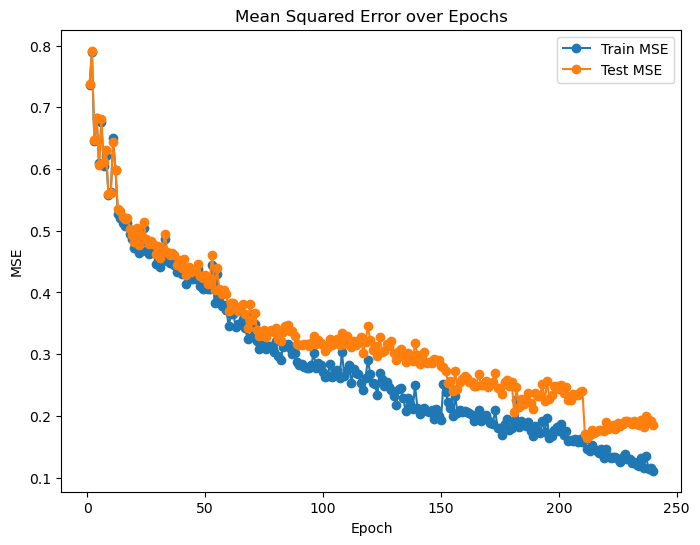

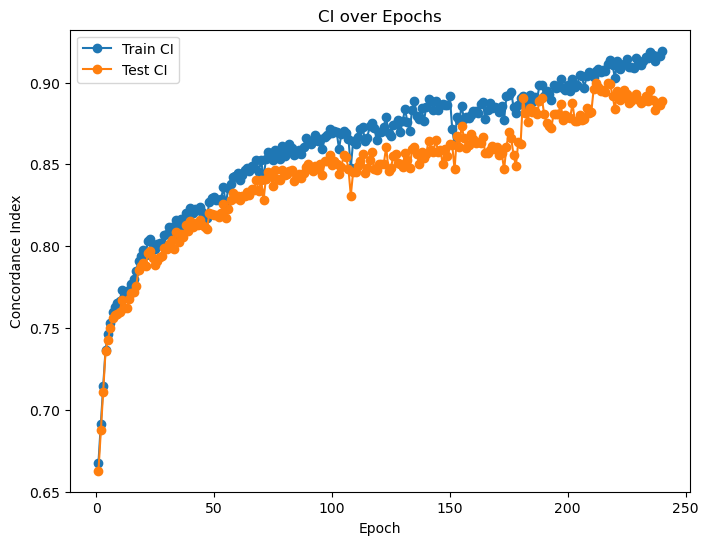

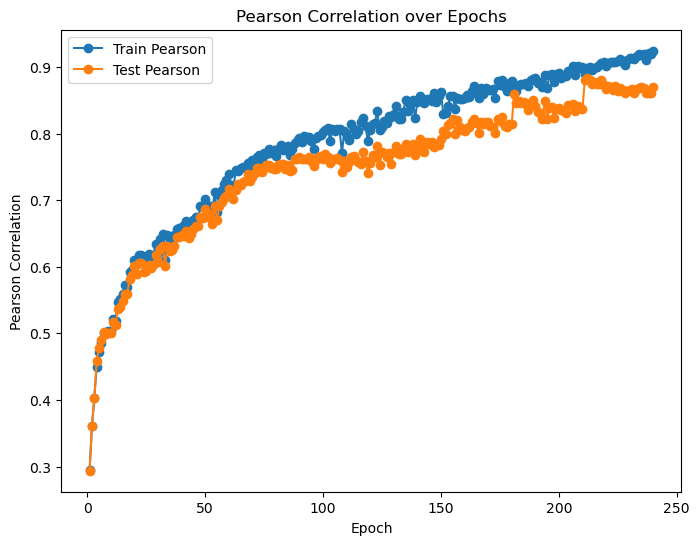

In [2]:
plot_metrics('')

In [ ]:

# import os
# import torch

# def train_and_evaluate(sample_dir, num_epochs=10, test_size=0.2, lr=0.001):
#     """
#     Trains the GNN model, evaluates on train & test each epoch, saves metrics + checkpoints.
#     """
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"Running on {device}.")

#     # Gather samples
#     sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.pt')]
#     assert len(sample_files) > 0, "No .pt files found in sample_dir!"

#     # Split
#     train_files, test_files = train_test_split(sample_files, test_size=test_size, random_state=42)

#     # Make checkpoint dir
#     training_model_dir = os.path.join(os.getcwd(), 'TrainingModelMul')
#     os.makedirs(training_model_dir, exist_ok=True)
#     print(f"Checkpoints will be saved to: {training_model_dir}")

#     metrics_path = os.path.join(training_model_dir, "training_metrics.pt")

#     # Load existing metrics if available (Ensures metrics continue from previous runs)
#     if os.path.exists(metrics_path):
#         saved_metrics = torch.load(metrics_path)
#         train_metrics = saved_metrics['train_metrics']
#         test_metrics = saved_metrics['test_metrics']
#         print("Loaded previous training metrics!")
#     else:
#         train_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
#         test_metrics = {'epoch': [], 'mse': [], 'ci': [], 'pearson': []}
#         print("Starting fresh metrics tracking.")

#     # Infer input dims from one sample
#     sample0 = load_sample(os.path.join(sample_dir, train_files[0]))
#     mol_data0, pro_data0 = sample0[0], sample0[1]
#     num_features_mol = mol_data0.x.size(1)
#     num_features_pro = pro_data0.x.size(1)

#     # Initialize model
#     model = GNNNet(num_features_mol=num_features_mol,
#                    num_features_pro=num_features_pro).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = MSELoss()

#     # Possibly resume from checkpoint
#     start_epoch = 1
#     existing_checkpoints = [
#         f for f in os.listdir(training_model_dir)
#         if f.endswith('.pt') and f.startswith('model_epoch')
#     ]
#     last_ckpt_path = None  # Track previous checkpoint for deletion

#     if existing_checkpoints:
#         latest_ckpt = max(existing_checkpoints, key=lambda x: int(x.split('_epoch')[1].split('.pt')[0]))
#         ckpt_path = os.path.join(training_model_dir, latest_ckpt)
#         print(f"Loading checkpoint from {ckpt_path}")
#         ckpt = torch.load(ckpt_path, map_location=device)
#         model.load_state_dict(ckpt['model_state_dict'])
#         optimizer.load_state_dict(ckpt['optimizer_state_dict'])
#         loaded_epoch = ckpt['epoch']
#         start_epoch = loaded_epoch + 1
#         last_ckpt_path = ckpt_path  # Store last checkpoint path for deletion
#         print(f"Resuming from epoch {start_epoch}")
#     else:
#         print("No existing checkpoint found; starting fresh.")

#     @torch.no_grad()
#     def evaluate(files):
#         model.eval()
#         all_preds = []
#         all_targets = []
#         batch_eval_size = 200
#         for batch_samples in batch_loader(files, sample_dir, batch_eval_size):
#             mol_list, pro_list, tgt_list = [], [], []
#             for (md, pd, t) in batch_samples:
#                 mol_list.append(md)
#                 pro_list.append(pd)
#                 tgt_list.append(t)

#             mol_batch = Batch.from_data_list(mol_list).to(device)
#             pro_batch = Batch.from_data_list(pro_list).to(device)
#             t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device)

#             out = model(mol_batch, pro_batch).view(-1)
#             all_preds.append(out)
#             all_targets.append(t_tensor)

#         all_preds = torch.cat(all_preds, dim=0)
#         all_targets = torch.cat(all_targets, dim=0)

#         mse_val = mse_torch(all_preds, all_targets)
#         ci_val = ci_vectorized(all_preds, all_targets)
#         pearson_val = pearson_torch(all_preds, all_targets)
#         return mse_val, ci_val, pearson_val

#     # Training loop
#     batch_size = 500
#     for epoch in tqdm(range(start_epoch, num_epochs + 1), desc="Training", unit="epoch"):
#         model.train()
#         running_loss = 0.0

#         for batch_samples in batch_loader(train_files, sample_dir, batch_size):
#             mol_list, pro_list, tgt_list = [], [], []
#             for (md, pd, t) in batch_samples:
#                 mol_list.append(md)
#                 pro_list.append(pd)
#                 tgt_list.append(t)

#             mol_batch = Batch.from_data_list(mol_list).to(device)
#             pro_batch = Batch.from_data_list(pro_list).to(device)
#             t_tensor = torch.tensor(tgt_list, dtype=torch.float32, device=device).view(-1)

#             optimizer.zero_grad()
#             out = model(mol_batch, pro_batch).view(-1)
#             loss = loss_fn(out, t_tensor)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * len(batch_samples)

#         avg_loss = running_loss / len(train_files)
#         tqdm.write(f"[Epoch {epoch}/{num_epochs}] Training Loss: {avg_loss:.4f}")

#         # Evaluate on train & test
#         train_mse, train_ci, train_pearson = evaluate(train_files)
#         test_mse, test_ci, test_pearson = evaluate(test_files)

#         train_metrics['epoch'].append(epoch)
#         train_metrics['mse'].append(train_mse)
#         train_metrics['ci'].append(train_ci)
#         train_metrics['pearson'].append(train_pearson)

#         test_metrics['epoch'].append(epoch)
#         test_metrics['mse'].append(test_mse)
#         test_metrics['ci'].append(test_ci)
#         test_metrics['pearson'].append(test_pearson)

#         tqdm.write(f"  Train => MSE={train_mse:.4f}, CI={train_ci:.4f}, Pearson={train_pearson:.4f}")
#         tqdm.write(f"  Test  => MSE={test_mse:.4f}, CI={test_ci:.4f}, Pearson={test_pearson:.4f}")

#         # Save new checkpoint
#         ckpt_name = f"model_epoch{epoch}.pt"
#         ckpt_path = os.path.join(training_model_dir, ckpt_name)
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#         }, ckpt_path)
#         tqdm.write(f"Checkpoint saved at epoch {epoch}")

#         # Delete the previous checkpoint after saving the new one
#         if last_ckpt_path and os.path.exists(last_ckpt_path):
#             os.remove(last_ckpt_path)
#             tqdm.write(f"Deleted previous checkpoint: {last_ckpt_path}")

#         # Update last checkpoint path
#         last_ckpt_path = ckpt_path

#         # Save/Update the metrics after each epoch
#         torch.save({
#             'train_metrics': train_metrics,
#             'test_metrics': test_metrics
#         }, metrics_path)

#     # Final evaluations
#     final_train_mse, final_train_ci, final_train_pearson = evaluate(train_files)
#     final_test_mse, final_test_ci, final_test_pearson = evaluate(test_files)
#     print(f"\nFinal Train => MSE={final_train_mse:.4f}, CI={final_train_ci:.4f}, Pearson={final_train_pearson:.4f}")
#     print(f"Final Test  => MSE={final_test_mse:.4f}, CI={final_test_ci:.4f}, Pearson={final_test_pearson:.4f}")

#     # Save final metrics
#     torch.save({
#         'train_metrics': train_metrics,
#         'test_metrics': test_metrics
#     }, metrics_path)
#     print(f"Metrics saved to {metrics_path}")

#     return train_metrics, test_metrics


# ##############################################################################
# #               5. OPTIONAL: PLOT THE SAVED METRICS
# ##############################################################################

# def plot_metrics(checkpoint_dir='TrainingModelMul'):
#     """
#     Load training_metrics.pt from the checkpoint_dir and plot MSE, CI, Pearson over epochs.
#     """
#     metrics_path = os.path.join(checkpoint_dir, "training_metrics.pt")
#     if not os.path.exists(metrics_path):
#         print(f"No metrics file found at {metrics_path}!")
#         return

#     saved_data = torch.load(metrics_path)
#     train_metrics = saved_data['train_metrics']
#     test_metrics = saved_data['test_metrics']
#     epochs = train_metrics['epoch']

#     # Plot MSE
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['mse'], 'o-', label='Train MSE')
#     plt.plot(epochs, test_metrics['mse'], 'o-', label='Test MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('MSE')
#     plt.title('Mean Squared Error over Epochs')
#     plt.legend()
#     plt.savefig(os.path.join(checkpoint_dir, "MSE_plot.png"))  
#     plt.show()

#     # Plot CI
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['ci'], 'o-', label='Train CI')
#     plt.plot(epochs, test_metrics['ci'], 'o-', label='Test CI')
#     plt.xlabel('Epoch')
#     plt.ylabel('Concordance Index')
#     plt.title('CI over Epochs')
#     plt.savefig(os.path.join(checkpoint_dir, "CI_plot.png"))  
#     plt.legend()
#     plt.show()

#     # Plot Pearson
#     plt.figure(figsize=(8, 6))
#     plt.plot(epochs, train_metrics['pearson'], 'o-', label='Train Pearson')
#     plt.plot(epochs, test_metrics['pearson'], 'o-', label='Test Pearson')
#     plt.xlabel('Epoch')
#     plt.ylabel('Pearson Correlation')
#     plt.title('Pearson Correlation over Epochs')
#     plt.legend()
#     plt.savefig(os.path.join(checkpoint_dir, "PEARSON_plot.png"))  
#     plt.show()

# ##############################################################################
# #                                 MAIN
# ##############################################################################

# if __name__ == "__main__":
#     # Adjust the paths/parameters as needed
#     SAMPLE_DIR = "prepared_samples"   # Directory with your .pt samples
#     NUM_EPOCHS = 250
#     TEST_SPLIT = 0.2
#     LR = 0.001

#     # 1) Train and evaluate
#     train_metrics, test_metrics = train_and_evaluate(
#         sample_dir=SAMPLE_DIR,
#         num_epochs=NUM_EPOCHS,
#         test_size=TEST_SPLIT,
#         lr=LR
#     )

#     # 2) Plot the metrics
#     plot_metrics('TrainingModelMul')